#  Imports

In [54]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from matplotlib.image import imread
from IPython.display import display, Image as IPImage
import shutil
import requests
from io import BytesIO

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Rescaling, Input, Dropout, Dense, BatchNormalization
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, Sequential, save_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications.resnet50 import preprocess_input

import tensorflow.keras.layers as layers
import tensorflow.keras.applications.resnet50 as resnet50
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
current_directory = os.getcwd()
parent_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
csv_path = os.path.join(parent_directory, "raw_data/computer_vision/pokemon.csv")
df = pd.read_csv(csv_path)


In [3]:
images_directory = os.path.join(parent_directory, "raw_data/computer_vision/images/")


# Exploration

In [4]:
df.head()


Name  Type1   Type2
0   bulbasaur  Grass  Poison
1     ivysaur  Grass  Poison
2    venusaur  Grass  Poison
3  charmander   Fire     NaN
4  charmeleon   Fire     NaN

In [5]:
images_directory


'/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/images/'

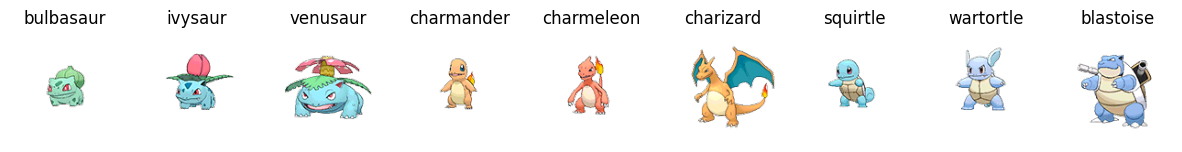

In [6]:
fig, axes = plt.subplots(1, 9, figsize=(15, 5))

for i, nom_pokemon in enumerate(df['Name'].head(9)):
    chemin_image_png = images_directory + nom_pokemon.lower() + ".png"
    chemin_image_jpg = images_directory + nom_pokemon.lower() + ".jpg"

    if os.path.exists(chemin_image_png):
        chemin_image = chemin_image_png
    elif os.path.exists(chemin_image_jpg):
        chemin_image = chemin_image_jpg
    else:
        print(f"Aucun fichier trouvé pour {nom_pokemon}")
        continue

    img = Image.open(chemin_image)

    axes[i].imshow(img)
    axes[i].set_title(nom_pokemon)
    axes[i].axis('off')

plt.show()


# Import OHE

In [7]:
df

Name     Type1   Type2
0      bulbasaur     Grass  Poison
1        ivysaur     Grass  Poison
2       venusaur     Grass  Poison
3     charmander      Fire     NaN
4     charmeleon      Fire     NaN
..           ...       ...     ...
804    stakataka      Rock   Steel
805  blacephalon      Fire   Ghost
806      zeraora  Electric     NaN
807       meltan     Steel     NaN
808     melmetal     Steel     NaN

[809 rows x 3 columns]

In [8]:
df = df.copy()
df = df.fillna('')
df

Name     Type1   Type2
0      bulbasaur     Grass  Poison
1        ivysaur     Grass  Poison
2       venusaur     Grass  Poison
3     charmander      Fire        
4     charmeleon      Fire        
..           ...       ...     ...
804    stakataka      Rock   Steel
805  blacephalon      Fire   Ghost
806      zeraora  Electric        
807       meltan     Steel        
808     melmetal     Steel        

[809 rows x 3 columns]

In [9]:
X = df['Type1']

In [10]:
# Use column transform for preprocessing only type1 and type2
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False, drop='first'), ['Type1', 'Type2'])
    ],
    remainder='passthrough'
)

In [11]:
# Use a pipelin for look perfectly the step
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['Type1', 'Type2'])]))])

In [12]:
# Apply the ohe
df_ohe = pipeline.fit_transform(df[['Type1', 'Type2']])

/home/morgane/.pyenv/versions/3.10.6/envs/catchemall/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [13]:
feature_names_out = pipeline.named_steps['preprocessor'].named_transformers_['onehot'].get_feature_names_out(['Type1', 'Type2'])

In [14]:
onehot_df = pd.DataFrame(df_ohe, columns=feature_names_out)

In [15]:
onehot_df

Type1_Dark  Type1_Dragon  Type1_Electric  Type1_Fairy  Type1_Fighting  \
0           0.0           0.0             0.0          0.0             0.0   
1           0.0           0.0             0.0          0.0             0.0   
2           0.0           0.0             0.0          0.0             0.0   
3           0.0           0.0             0.0          0.0             0.0   
4           0.0           0.0             0.0          0.0             0.0   
..          ...           ...             ...          ...             ...   
804         0.0           0.0             0.0          0.0             0.0   
805         0.0           0.0             0.0          0.0             0.0   
806         0.0           0.0             1.0          0.0             0.0   
807         0.0           0.0             0.0          0.0             0.0   
808         0.0           0.0             0.0          0.0             0.0   

     Type1_Fire  Type1_Flying  Type1_Ghost  Type1_Grass  Type1_Ground  ...  \
0           0.0           0.0          0.0          1.0           0.0  ...   
1           0.0           0.0          0.0          1.0           0.0  ...   
2           0.0           0.0          0.0          1.0           0.0  ...   
3           1.0           0.0          0.0          0.0           0.0  ...   
4           1.0           0.0          0.0          0.0           0.0  ...   
..          ...           ...          ...          ...           ...  ...   
804         0.0           0.0          0.0          0.0           0.0  ...   
805         1.0           0.0          0.0          0.0           0.0  ...   
806         0.0           0.0          0.0          0.0           0.0  ...   
807         0.0           0.0          0.0          0.0           0.0  ...   
808         0.0           0.0          0.0          0.0           0.0  ...   

     Type2_Ghost  Type2_Grass  Type2_Ground  Type2_Ice  Type2_Normal  \
0            0.0          0.0           0.0        0.0           0.0   
1            0.0          0.0           0.0        0.0           0.0   
2            0.0          0.0           0.0        0.0           0.0   
3            0.0          0.0           0.0        0.0           0.0   
4            0.0          0.0           0.0        0.0           0.0   
..           ...          ...           ...        ...           ...   
804          0.0          0.0           0.0        0.0           0.0   
805          1.0          0.0           0.0        0.0           0.0   
806          0.0          0.0           0.0        0.0           0.0   
807          0.0          0.0           0.0        0.0           0.0   
808          0.0          0.0           0.0        0.0           0.0   

     Type2_Poison  Type2_Psychic  Type2_Rock  Type2_Steel  Type2_Water  
0             1.0            0.0         0.0          0.0          0.0  
1             1.0            0.0         0.0          0.0          0.0  
2             1.0            0.0         0.0          0.0          0.0  
3             0.0            0.0         0.0          0.0          0.0  
4             0.0            0.0         0.0          0.0          0.0  
..            ...            ...         ...          ...          ...  
804           0.0            0.0         0.0          1.0          0.0  
805           0.0            0.0         0.0          0.0          0.0  
806           0.0            0.0         0.0          0.0          0.0  
807           0.0            0.0         0.0          0.0          0.0  
808           0.0            0.0         0.0          0.0          0.0  

[809 rows x 35 columns]

In [16]:
# Delet the prefixe Type_1 and Type_2 for every columns

for col in onehot_df.columns:
    if col.startswith('Type1_'):
        onehot_df.rename(columns={col: col.replace('Type1_', '')}, inplace=True)
    elif col.startswith('Type2_'):
        onehot_df.rename(columns={col: col.replace('Type2_', '')}, inplace=True)
onehot_df

Dark  Dragon  Electric  Fairy  Fighting  Fire  Flying  Ghost  Grass  \
0     0.0     0.0       0.0    0.0       0.0   0.0     0.0    0.0    1.0   
1     0.0     0.0       0.0    0.0       0.0   0.0     0.0    0.0    1.0   
2     0.0     0.0       0.0    0.0       0.0   0.0     0.0    0.0    1.0   
3     0.0     0.0       0.0    0.0       0.0   1.0     0.0    0.0    0.0   
4     0.0     0.0       0.0    0.0       0.0   1.0     0.0    0.0    0.0   
..    ...     ...       ...    ...       ...   ...     ...    ...    ...   
804   0.0     0.0       0.0    0.0       0.0   0.0     0.0    0.0    0.0   
805   0.0     0.0       0.0    0.0       0.0   1.0     0.0    0.0    0.0   
806   0.0     0.0       1.0    0.0       0.0   0.0     0.0    0.0    0.0   
807   0.0     0.0       0.0    0.0       0.0   0.0     0.0    0.0    0.0   
808   0.0     0.0       0.0    0.0       0.0   0.0     0.0    0.0    0.0   

     Ground  ...  Ghost  Grass  Ground  Ice  Normal  Poison  Psychic  Rock  \
0       0.0  ...    0.0    0.0     0.0  0.0     0.0     1.0      0.0   0.0   
1       0.0  ...    0.0    0.0     0.0  0.0     0.0     1.0      0.0   0.0   
2       0.0  ...    0.0    0.0     0.0  0.0     0.0     1.0      0.0   0.0   
3       0.0  ...    0.0    0.0     0.0  0.0     0.0     0.0      0.0   0.0   
4       0.0  ...    0.0    0.0     0.0  0.0     0.0     0.0      0.0   0.0   
..      ...  ...    ...    ...     ...  ...     ...     ...      ...   ...   
804     0.0  ...    0.0    0.0     0.0  0.0     0.0     0.0      0.0   0.0   
805     0.0  ...    1.0    0.0     0.0  0.0     0.0     0.0      0.0   0.0   
806     0.0  ...    0.0    0.0     0.0  0.0     0.0     0.0      0.0   0.0   
807     0.0  ...    0.0    0.0     0.0  0.0     0.0     0.0      0.0   0.0   
808     0.0  ...    0.0    0.0     0.0  0.0     0.0     0.0      0.0   0.0   

     Steel  Water  
0      0.0    0.0  
1      0.0    0.0  
2      0.0    0.0  
3      0.0    0.0  
4      0.0    0.0  
..     ...    ...  
804    1.0    0.0  
805    0.0    0.0  
806    0.0    0.0  
807    0.0    0.0  
808    0.0    0.0  

[809 rows x 35 columns]

In [17]:
merged_df = onehot_df.groupby(level=0, axis=1).sum()

In [18]:
df_ohe = pd.concat([df, merged_df], axis=1)

In [19]:
df_ohe = df_ohe.drop(['Type1', 'Type2'], axis=1)

In [20]:
df_ohe

Name  Bug  Dark  Dragon  Electric  Fairy  Fighting  Fire  Flying  \
0      bulbasaur  0.0   0.0     0.0       0.0    0.0       0.0   0.0     0.0   
1        ivysaur  0.0   0.0     0.0       0.0    0.0       0.0   0.0     0.0   
2       venusaur  0.0   0.0     0.0       0.0    0.0       0.0   0.0     0.0   
3     charmander  0.0   0.0     0.0       0.0    0.0       0.0   1.0     0.0   
4     charmeleon  0.0   0.0     0.0       0.0    0.0       0.0   1.0     0.0   
..           ...  ...   ...     ...       ...    ...       ...   ...     ...   
804    stakataka  0.0   0.0     0.0       0.0    0.0       0.0   0.0     0.0   
805  blacephalon  0.0   0.0     0.0       0.0    0.0       0.0   1.0     0.0   
806      zeraora  0.0   0.0     0.0       1.0    0.0       0.0   0.0     0.0   
807       meltan  0.0   0.0     0.0       0.0    0.0       0.0   0.0     0.0   
808     melmetal  0.0   0.0     0.0       0.0    0.0       0.0   0.0     0.0   

     Ghost  Grass  Ground  Ice  Normal  Poison  Psychic  Rock  Steel  Water  
0      0.0    1.0     0.0  0.0     0.0     1.0      0.0   0.0    0.0    0.0  
1      0.0    1.0     0.0  0.0     0.0     1.0      0.0   0.0    0.0    0.0  
2      0.0    1.0     0.0  0.0     0.0     1.0      0.0   0.0    0.0    0.0  
3      0.0    0.0     0.0  0.0     0.0     0.0      0.0   0.0    0.0    0.0  
4      0.0    0.0     0.0  0.0     0.0     0.0      0.0   0.0    0.0    0.0  
..     ...    ...     ...  ...     ...     ...      ...   ...    ...    ...  
804    0.0    0.0     0.0  0.0     0.0     0.0      0.0   1.0    1.0    0.0  
805    1.0    0.0     0.0  0.0     0.0     0.0      0.0   0.0    0.0    0.0  
806    0.0    0.0     0.0  0.0     0.0     0.0      0.0   0.0    0.0    0.0  
807    0.0    0.0     0.0  0.0     0.0     0.0      0.0   0.0    1.0    0.0  
808    0.0    0.0     0.0  0.0     0.0     0.0      0.0   0.0    1.0    0.0  

[809 rows x 19 columns]

# Création dossiers par type de Pokémon

In [21]:
types = set(df['Type1'])
types


{'Bug',
 'Dark',
 'Dragon',
 'Electric',
 'Fairy',
 'Fighting',
 'Fire',
 'Flying',
 'Ghost',
 'Grass',
 'Ground',
 'Ice',
 'Normal',
 'Poison',
 'Psychic',
 'Rock',
 'Steel',
 'Water'}

In [22]:
parent_directory


'/home/morgane/code/mtthibault/catchemall'

In [23]:
types_directory = os.path.join(parent_directory, "raw_data/computer_vision/types/")
types_directory


'/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/types/'

In [24]:
# for pokemon_type in types:
#     type_directory_path = os.path.join(types_directory, pokemon_type)
#     # Pour vérifier si dossier existe déjà, sinon créer
#     if not os.path.exists(type_directory_path):
#         os.makedirs(type_directory_path)


# Rangement des pokémons par dossier Type

In [25]:
# for index, row in df.iterrows():
#     pokemon_name = row['Name']
#     type1 = row['Type1']
#     type2 = str(row['Type2'])  # str pcq sinon ça bug à cause des NaN

#     type1_directory_path = os.path.join(types_directory, type1)
#     if os.path.exists(type1_directory_path):
#         for ext in ['jpg', 'png']:
#             source_image_path = os.path.join(images_directory, f'{pokemon_name}.{ext}')
#             if os.path.exists(source_image_path):
#                 destination_path = os.path.join(type1_directory_path, f'{pokemon_name}.{ext}')
#                 shutil.copy(source_image_path, destination_path)
#                 break

#     # Vérifier si le type 2 existe et copier l'image
#     if type2:
#         type2_directory_path = os.path.join(types_directory, type2)
#         if os.path.exists(type2_directory_path):
#             for ext in ['jpg', 'png']:
#                 source_image_path = os.path.join(images_directory, f'{pokemon_name}.{ext}')
#                 if os.path.exists(source_image_path):
#                     destination_path = os.path.join(type2_directory_path, f'{pokemon_name}.{ext}')
#                     shutil.copy(source_image_path, destination_path)
#                     break


# Exploration 2

In [26]:
types_path = '/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/types'
types_path


'/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/types'

In [27]:
pokemon_dict = {}


In [28]:
os.listdir(types_path)


['Ghost',
 'Fighting',
 'Ground',
 'Dark',
 'Flying',
 'Normal',
 'Steel',
 'Grass',
 'Ice',
 'Rock',
 'Water',
 'Electric',
 'Psychic',
 'Bug',
 'Fairy',
 'Fire',
 'Poison',
 'Dragon']

In [29]:
for type_folder in os.listdir(types_path):
    type_folder_path = os.path.join(types_path, type_folder) #donc là j'ai le chemin pour chaqun de mes folders TYPE

    # vérifie si le chemin est un dossier
    if os.path.isdir(type_folder_path):
        pokemon_names = [] # Jstock les noms des pokémons pour le type actuel

        # parcours de chaque image dans le dossier du type actuel
        for file_name in os.listdir(type_folder_path):
            # pour gérer png jpg
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                pokemon_name = os.path.splitext(file_name)[0] #pour split l'extension .png .jpg cimer chatgpt
                pokemon_names.append(pokemon_name) #J'ajoute le nom du pokémon à la liste

        pokemon_dict[type_folder] = pokemon_names


In [30]:
pokemon_dict


{'Ghost': ['Dusknoir_29091',
  'Shuppet_23440',
  'Misdreavus_14867',
  'Sableye_20798',
  'Honedge_34316',
  'Dusclops_23606',
  'Shedinja_20325',
  'Shedinja_20306',
  'Litwick_32699',
  'Lampent_32721',
  'Lampent_32731',
  'Cofagrigus_31543',
  'Jellicent_32358',
  'Haunter_7147',
  'Duskull_23529',
  'Chandelure_32756',
  'Jellicent_32355',
  'Spiritomb_27565',
  'Misdreavus_14887',
  'Gengar_7177',
  'Gengar_7178',
  'Jellicent_32334',
  'Shedinja_20321',
  'Shuppet_23427',
  'Banette_23504',
  'Rotom_29176',
  'Spiritomb_27578',
  'Duskull_23558',
  'Misdreavus_14852',
  'golett',
  'Dusclops_23612',
  'Phantump_34822',
  'Froslass_29165',
  'Frillish_32306',
  'Haunter_7157',
  'Palossand_35661',
  'Drifloon_26829',
  'Shuppet_23445',
  'Froslass_29162',
  'Spiritomb_27556',
  'Jellicent_32342',
  'Misdreavus_14886',
  'Shedinja_20329',
  'Gastly_7039',
  'Trevenant_34845',
  'Gastly_7074',
  'Mismagius_27018',
  'Misdreavus_14900',
  'Misdreavus_14899',
  'Froslass_29151',
  '

In [31]:
len(pokemon_dict['Bug'])


3318

In [32]:
pokemon_names

['Fraxure_32800',
 'Dratini_11336',
 'axew',
 'Kingdra_16893',
 'Gible_27624',
 'Sliggoo_34770',
 'salamence',
 'Dialga_29375',
 'guzzlord',
 'Dragonair_11403',
 'Latios_24935',
 'Tyrantrum_34609',
 'Axew_32762',
 'Flygon_22235',
 'Dragonite_11506',
 'Haxorus_32811',
 'shelgon',
 'Flygon_22237',
 'Noibat_34919',
 'Dragonair_11426',
 'Goodra_34791',
 'Dragonair_11436',
 'Rayquaza_25084',
 'Dratini_11291',
 'Tyrantrum_34596',
 'Altaria_22449',
 'Salamence_24489',
 'Dragonite_11511',
 'Noibat_34931',
 'goodra',
 'Dialga_29360',
 'dragonite',
 'Bagon_24420',
 'Altaria_22461',
 'Garchomp_27686',
 'Garchomp_27715',
 'Sliggoo_34763',
 'Gible_27597',
 'Shelgon_24450',
 'Fraxure_32799',
 'Bagon_24406',
 'Gible_27587',
 'Dragonair_11381',
 'Gabite_27627',
 'Zweilous_33403',
 'Rayquaza_25080',
 'Sliggoo_34755',
 'Gible_27602',
 'Bagon_24376',
 'Flygon_22240',
 'Zekrom_33688',
 'Latias_24883',
 'Bagon_24384',
 'Axew_32782',
 'Altaria_22470',
 'haxorus',
 'Kyurem_33771',
 'Salamence_24512',
 'Goomy

Type: Ghost


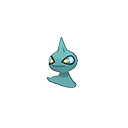

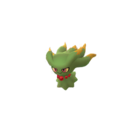



Type: Fighting


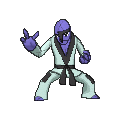

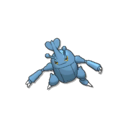

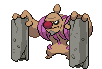



Type: Ground


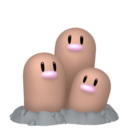

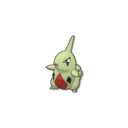

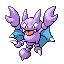



Type: Dark


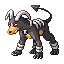

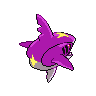

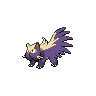



Type: Flying


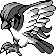

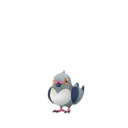

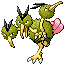



Type: Normal


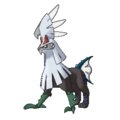

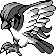

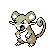



Type: Steel


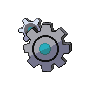

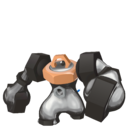

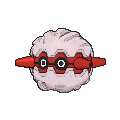



Type: Grass


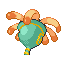

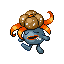

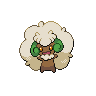



Type: Ice


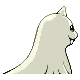

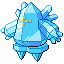

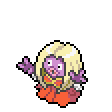



Type: Rock


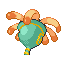

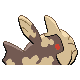

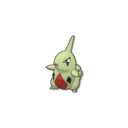



Type: Water


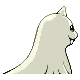

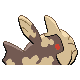

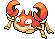



Type: Electric


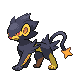

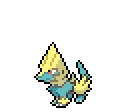

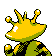



Type: Psychic


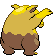

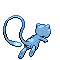

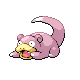



Type: Bug


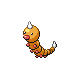

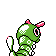

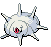



Type: Fairy


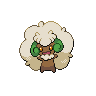

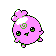

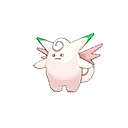



Type: Fire


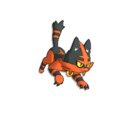

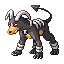

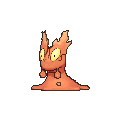



Type: Poison


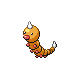

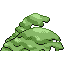

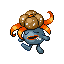



Type: Dragon


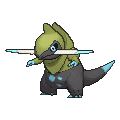

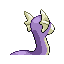

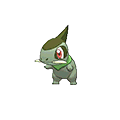

In [33]:
num_images_to_display = 3

for pokemon_type, pokemon_names in pokemon_dict.items():
    print(f"Type: {pokemon_type}")
    
    for name in pokemon_names[:num_images_to_display]:
        for extension in ['.jpg', '.jpeg', '.png']:
            image_path = os.path.join(types_path, pokemon_type, f"{name}{extension}")
            
            if os.path.exists(image_path):
                display(IPImage(filename=image_path))
                break
    
    print("\n")

# Analyse

In [34]:
y = list(df['Type1'].unique())
y

['Grass',
 'Fire',
 'Water',
 'Bug',
 'Normal',
 'Poison',
 'Electric',
 'Ground',
 'Fairy',
 'Fighting',
 'Psychic',
 'Rock',
 'Ghost',
 'Ice',
 'Dragon',
 'Dark',
 'Steel',
 'Flying']

In [35]:
types_path

'/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/types'

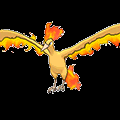

In [36]:
img = load_img(f"{types_path}/Fire/moltres.png")
img

In [37]:
x = img_to_array(img)
x

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [38]:
x.shape

(120, 120, 3)

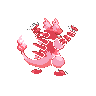

In [39]:
img = load_img(f"{types_path}/Fire/Magmar_9657.png")
img

In [40]:
x = img_to_array(img)
x.shape

(96, 96, 3)

# Models

## Train/Test

In [41]:
train_data_dir = parent_directory + "/raw_data/computer_vision/train_test/train/"
test_data_dir = parent_directory + "/raw_data/computer_vision/train_test/test/"
print(train_data_dir)
print(test_data_dir)

/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/train_test/train/
/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/train_test/test/


In [42]:
target_size = (120, 120)

def resize_image(image_path):
    img = Image.open(image_path)
    img_resized = img.resize(target_size, Image.LANCZOS)

    # Forcer le mode de l'image à rester en RGB sinon kk
    img_array = img_to_array(img_resized, data_format="channels_last", dtype="uint8")

    img.close()
    return img_array

def resize_images_in_directory(directory):
    # Parcourir les sous-dossiers
    for poketype_folder in os.listdir(directory):
        poketype_folder_path = os.path.join(directory, poketype_folder)

        if os.path.isdir(poketype_folder_path):
            # pour suivre que ya rien qui crash
            print(f"Redimensionnement des images dans le dossier {poketype_folder}...")

            # Créer un sous-dossier 'resized' pour sauvegarder les images redimensionnées
            resized_folder_path = os.path.join(poketype_folder_path, 'resized')
            os.makedirs(resized_folder_path, exist_ok=True)

            # Parcourir les images dans le dossier de chaque type
            image_files = [f for f in os.listdir(poketype_folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

            for image_file in image_files:
                image_path = os.path.join(poketype_folder_path, image_file)

                try:
                    resized_image_array = resize_image(image_path)

                    rescale_layer = Rescaling(scale=1./255)
                    resized_image_array = rescale_layer(np.expand_dims(resized_image_array, axis=0))[0]

                    save_path = os.path.join(resized_folder_path, image_file)
                    array_to_img(resized_image_array).save(save_path)
                except ValueError as e:
                    print(f"Ignoré l'image {image_file} dans le dossier {poketype_folder} : {e}") # ignorer sinon crash
                    continue

In [43]:
# resize_images_in_directory(train_data_dir)

In [44]:
# resize_images_in_directory(test_data_dir)

In [45]:
# x.shape

In [46]:
train_ds = image_dataset_from_directory(train_data_dir,
                                        labels="inferred",
                                        label_mode="categorical",
                                        image_size=(120,120),
                                        batch_size=32,
                                        seed=123)

train_ds

Found 42500 files belonging to 18 classes.


2023-12-12 19:53:34.047391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-12 19:53:34.047525: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-12 19:53:34.047579: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-12-12 19:53:34.047609: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-12-12 19:53:34.047638: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

<BatchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None))>

In [47]:
train_ds.class_names

['Bug_train',
 'Dark_train',
 'Dragon_train',
 'Electric_train',
 'Fairy_train',
 'Fighting_train',
 'Fire_train',
 'Flying_train',
 'Ghost_train',
 'Grass_train',
 'Ground_train',
 'Ice_train',
 'Normal_train',
 'Poison_train',
 'Psychic_train',
 'Rock_train',
 'Steel_train',
 'Water_train']

In [48]:
val_ds = image_dataset_from_directory(test_data_dir,
                                      labels="inferred",
                                      label_mode="categorical",
                                      image_size=(120,120),
                                      batch_size=32,
                                      seed=123)

val_ds

Found 10635 files belonging to 18 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None))>

In [49]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    # LOSS
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[0].legend()
    ax[0].grid()
    
    # ACCURACY
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[1].legend()
    ax[1].grid()

In [50]:
def plot_loss_accuracy(history):

    fig, ax = plt.subplots(1, 2, figsize=(15, 4))

    ## Plot Losses and Accuracies
    x_axis = np.arange(len(history.history['loss']))

    ax[0].set_title("Loss")
    ax[0].plot(x_axis, history.history['loss'], color="blue", linestyle=":", marker="X", label="Train Loss")
    ax[0].plot(x_axis, history.history['val_loss'], color="orange", linestyle="-", marker="X", label="Val Loss")

    ax[1].set_title("Accuracy")
    ax[1].plot(x_axis, history.history['accuracy'], color="blue", linestyle=":", marker="X", label="Train Accuracy")
    ax[1].plot(x_axis,
               history.history['val_accuracy'],
               color="orange",
               linestyle="-",
               marker="X",
               label="Val Accuracy")

    ## Customization
    ax[0].grid(axis="x", linewidth=0.5)
    ax[0].grid(axis="y", linewidth=0.5)
    ax[0].legend()

    ax[1].grid(axis="x", linewidth=0.5)
    ax[1].grid(axis="y", linewidth=0.5)
    ax[1].legend()


    plt.show()

## CNN (12/12/2023) : ResNet V3 (doggos 101)

In [51]:
base_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(120, 120, 3)) # Chargement du modèle de base ResNet50 pré-entraîné

base_model.trainable = False # Gèle les poids du modèle de base

model_doggo = tf.keras.Sequential([
    layers.Input((120, 120, 3)),
    layers.experimental.preprocessing.RandomFlip(mode='horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    base_model, # base modèle ResNet50 ajouté en tant que couche
    layers.GlobalAveragePooling2D(), # pour réduire la dimensionnalité spatiale
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(18, activation='softmax')
])

def preprocess(img, label):
    img = resnet50.preprocess_input(img) # fonction preprocess_input de ResNet50 pour normaliser les images
    return img, label

es = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1) # réduit le taux d'apprentissage si besoin

train_ds_prepro = train_ds.map(preprocess) # applique la fonction de prétraitement aux ensembles de données d'entraînement et de validation
validation_ds_prepro = val_ds.map(preprocess) # applique la fonction de prétraitement aux ensembles de données d'entraînement et de validation

model_doggo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_doggo = model_doggo.fit(train_ds_prepro, 
                    validation_data=validation_ds_prepro, 
                    epochs=50,
                    callbacks=[es, rlr],
                    verbose=1)

Epoch 1/50
1329/1329 [==============================] - 283s 211ms/step - loss: 2.5523 - accuracy: 0.2002 - val_loss: 2.3211 - val_accuracy: 0.2683 - lr: 0.0010
Epoch 2/50
1329/1329 [==============================] - 278s 209ms/step - loss: 2.3482 - accuracy: 0.2478 - val_loss: 2.2042 - val_accuracy: 0.2946 - lr: 0.0010
Epoch 3/50
1329/1329 [==============================] - 277s 209ms/step - loss: 2.2368 - accuracy: 0.2776 - val_loss: 2.1364 - val_accuracy: 0.3020 - lr: 0.0010
Epoch 4/50
1329/1329 [==============================] - 276s 208ms/step - loss: 2.1746 - accuracy: 0.2920 - val_loss: 2.0874 - val_accuracy: 0.3205 - lr: 0.0010
Epoch 5/50
1329/1329 [==============================] - 277s 208ms/step - loss: 2.1194 - accuracy: 0.3077 - val_loss: 2.0297 - val_accuracy: 0.3369 - lr: 0.0010
Epoch 6/50
1329/1329 [==============================] - 278s 209ms/step - loss: 2.0746 - accuracy: 0.3166 - val_loss: 2.0231 - val_accuracy: 0.3381 - lr: 0.0010
Epoch 7/50
1329/1329 [============

1329/1329 [==============================] - 279s 210ms/step - loss: 1.6183 - accuracy: 0.4301 - val_loss: 1.6434 - val_accuracy: 0.4151 - lr: 1.0000e-04
Epoch 36/50
1329/1329 [==============================] - 279s 210ms/step - loss: 1.6134 - accuracy: 0.4331 - val_loss: 1.6459 - val_accuracy: 0.4125 - lr: 1.0000e-04
Epoch 37/50
1329/1329 [==============================] - 279s 210ms/step - loss: 1.6023 - accuracy: 0.4331 - val_loss: 1.6410 - val_accuracy: 0.4200 - lr: 1.0000e-04
Epoch 38/50
1329/1329 [==============================] - 278s 209ms/step - loss: 1.6136 - accuracy: 0.4312 - val_loss: 1.6371 - val_accuracy: 0.4175 - lr: 1.0000e-04
Epoch 39/50
1329/1329 [==============================] - 279s 210ms/step - loss: 1.5983 - accuracy: 0.4369 - val_loss: 1.6343 - val_accuracy: 0.4174 - lr: 1.0000e-04
Epoch 40/50
1329/1329 [==============================] - 278s 209ms/step - loss: 1.6041 - accuracy: 0.4362 - val_loss: 1.6345 - val_accuracy: 0.4165 - lr: 1.0000e-04
Epoch 41/50
1329

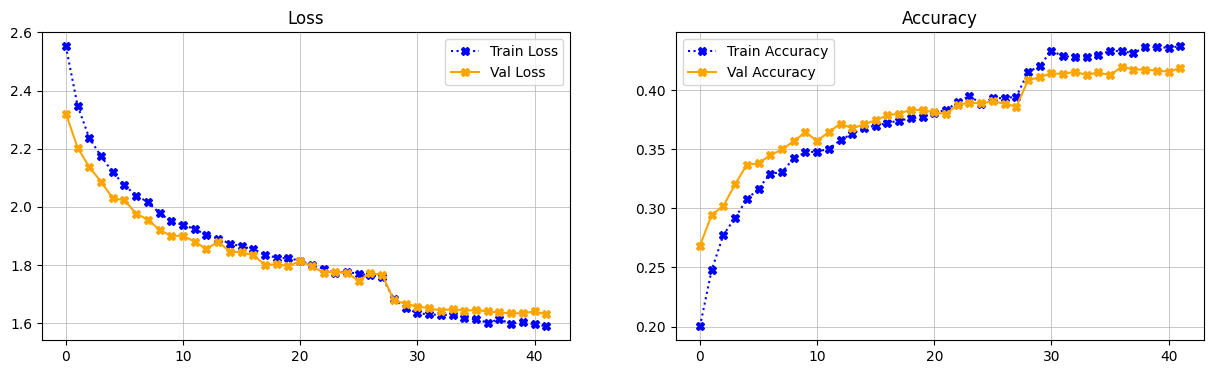

In [52]:
plot_loss_accuracy(history_doggo)

# Saving & loading the model

In [55]:
model_doggo.save("final_resnet_keras.keras")
model_doggo.save("final_resnet_h5.h5")
models.save_model(model_doggo, 'final_resnet')

INFO:tensorflow:Assets written to: final_resnet/assets


INFO:tensorflow:Assets written to: final_resnet/assets


In [56]:
from tensorflow.keras.models import load_model
loaded_model = load_model("final_resnet_keras.keras")

In [57]:
loaded_model

# Predictions

In [58]:
target_size = (120,120)

In [59]:
types

{'Bug',
 'Dark',
 'Dragon',
 'Electric',
 'Fairy',
 'Fighting',
 'Fire',
 'Flying',
 'Ghost',
 'Grass',
 'Ground',
 'Ice',
 'Normal',
 'Poison',
 'Psychic',
 'Rock',
 'Steel',
 'Water'}

In [ ]:
# # Grabs an image based on its URL, and resize it
# def getImage(url):
#     response = requests.get(url)
#     img = Image.open(BytesIO(response.content))
#     plt.imshow(img)
#     img = img.resize((120, 120))
#     return img

In [ ]:
# def resize_prediction(url):
#     img = getImage(url)
#     img_resized = img.resize(target_size, Image.LANCZOS)
    
#     img_resized = img_resized.convert('RGB')

#     img_array = img_to_array(img_resized, data_format="channels_last", dtype="uint8")

#     return img_array

In [ ]:
# groubix = loaded_model.predict(val_ds)
# groubix[0]

In [ ]:
# # Takes an image and a model
# def predictImage(url, model):
#     # Get the image
#     resized_image_array = resize_prediction(url)
    
#     # Reshape the image
#     img = resized_image_array.reshape((120, 120, 3))
#     img = resnet50.preprocess_input(img) # !!! à changer en fonction du modèle utilisé
    
#     # Make predictions
#     res = model.predict(np.expand_dims(img, axis=0))

#     types = train_ds.class_names

#     top3_probs = np.sort(res, axis=-1)[:, -3:]
#     top3_classes = np.argsort(res, axis=1)[:, -3:]
    
#     predicted_index_1 = top3_classes[0][-1]
#     predicted_proba_1 = round(top3_probs[0][-1]*100,2)
#     predicted_index_2 = top3_classes[0][-2]
#     predicted_proba_2 = round(top3_probs[0][-2]*100,2)
#     predicted_index_3 = top3_classes[0][-3]
#     predicted_proba_3 = round(top3_probs[0][-3]*100,2)

#     print(f"First predicted type: {types[predicted_index_1]}: {predicted_proba_1}%")
#     print(f"Second predicted type: {types[predicted_index_2]}: {predicted_proba_2}%")
#     print(f"Third predicted type: {types[predicted_index_3]}: {predicted_proba_3}%")

In [60]:
def getImage(source):

    #upload image
    if type(source) == PIL.Image.Image:
        img = source

    #chemin image
    elif os.path.exists(source):
        img = Image.open(source)

    #url image
    else:
        response = requests.get(source)
        img = Image.open(BytesIO(response.content))

    plt.imshow(img)
    img = img.resize((120, 120))
    return img

In [61]:
def resize_prediction(source):
    img = getImage(source)
    img_resized = img.resize(target_size, Image.LANCZOS)

    img_resized = img_resized.convert('RGB')
    img_array = img_to_array(img_resized, data_format="channels_last", dtype="uint8")

    return img_array

In [62]:
def predictImage(source, model):
    # Get the image
    resized_image_array = resize_prediction(source)
    
    # Reshape the image
    img = resized_image_array.reshape((target_size[0], target_size[1], 3))
    img = resnet50.preprocess_input(img)
    
    # Make predictions
    res = model.predict(np.expand_dims(img, axis=0))

    types = train_ds.class_names

    top3_probs = np.sort(res, axis=-1)[:, -3:]
    top3_classes = np.argsort(res, axis=1)[:, -3:]
    
    predicted_index_1 = top3_classes[0][-1]
    predicted_proba_1 = round(top3_probs[0][-1] * 100, 2)
    predicted_index_2 = top3_classes[0][-2]
    predicted_proba_2 = round(top3_probs[0][-2] * 100, 2)
    predicted_index_3 = top3_classes[0][-3]
    predicted_proba_3 = round(top3_probs[0][-3] * 100, 2)

    print(f"First predicted type: {types[predicted_index_1]}: {predicted_proba_1}%")
    print(f"Second predicted type: {types[predicted_index_2]}: {predicted_proba_2}%")
    print(f"Third predicted type: {types[predicted_index_3]}: {predicted_proba_3}%")

In [63]:
grass = "https://archives.bulbagarden.net/media/upload/0/0c/0810Grookey.png"
firebug = "https://archives.bulbagarden.net/media/upload/8/83/0851Centiskorch.png"
grasspsychic = "https://archives.bulbagarden.net/media/upload/8/80/1010Iron_Leaves.png"
normalflying = "https://archives.bulbagarden.net/media/upload/b/b3/HOME0931W.png"

1/1 [==============================] - 1s 583ms/step
First predicted type: Water_train: 35.65%
Second predicted type: Fighting_train: 16.25%
Third predicted type: Ground_train: 7.53%


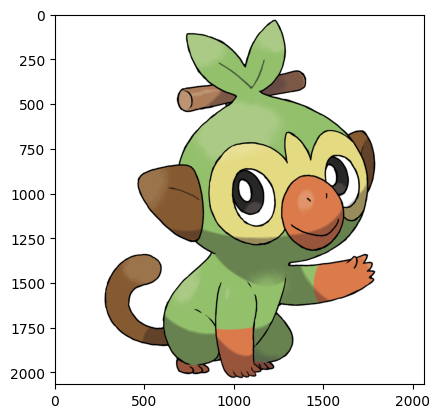

In [64]:
predictImage(grass, loaded_model)

1/1 [==============================] - 0s 50ms/step
First predicted type: Fire_train: 62.27%
Second predicted type: Electric_train: 20.68%
Third predicted type: Flying_train: 15.77%


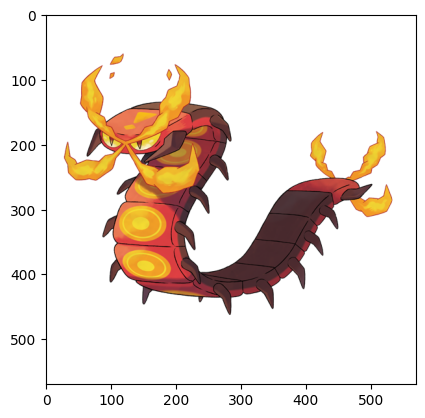

In [65]:
predictImage(firebug, loaded_model) #DEMO

1/1 [==============================] - 0s 50ms/step
First predicted type: Ground_train: 23.93%
Second predicted type: Poison_train: 20.89%
Third predicted type: Grass_train: 14.32%


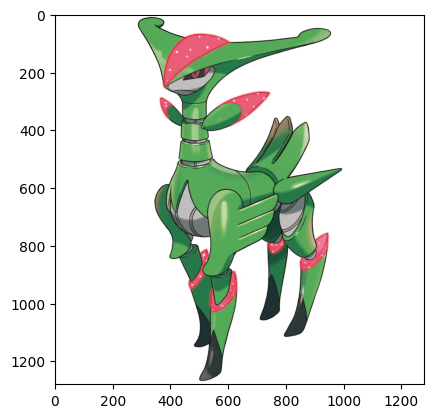

In [66]:
predictImage(grasspsychic, loaded_model)

1/1 [==============================] - 0s 52ms/step
First predicted type: Water_train: 33.85%
Second predicted type: Psychic_train: 9.46%
Third predicted type: Grass_train: 8.55%


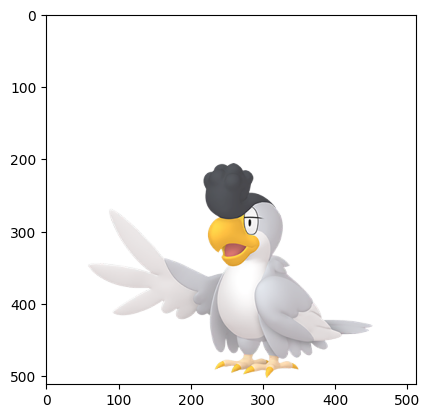

In [67]:
predictImage(normalflying, loaded_model)

1/1 [==============================] - 0s 52ms/step
First predicted type: Bug_train: 63.9%
Second predicted type: Flying_train: 33.22%
Third predicted type: Poison_train: 1.48%


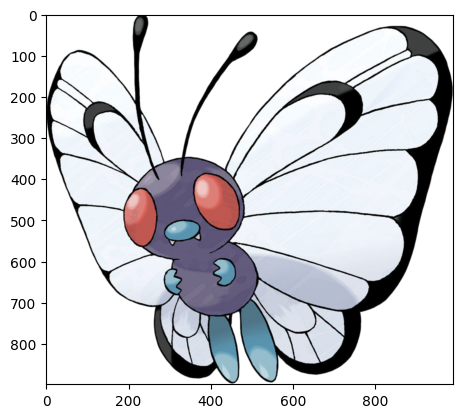

In [68]:
papi = "https://www.pokepedia.fr/images/thumb/8/83/Papilusion-RFVF.png/989px-Papilusion-RFVF.png?20200407160850"
predictImage(papi, loaded_model)

1/1 [==============================] - 0s 45ms/step
First predicted type: Water_train: 50.04%
Second predicted type: Fairy_train: 28.95%
Third predicted type: Psychic_train: 9.48%


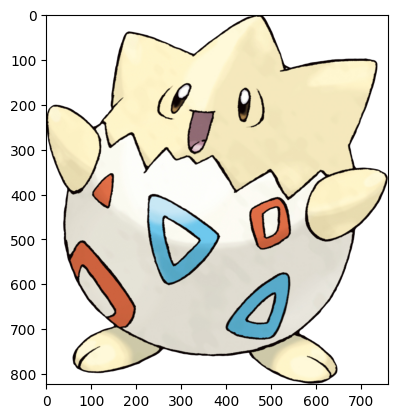

In [69]:
togepi = "https://www.pokepedia.fr/images/8/8f/Togepi-RFVF.png?20200407220006"
predictImage(togepi, loaded_model)

1/1 [==============================] - 0s 55ms/step
First predicted type: Fire_train: 73.22%
Second predicted type: Flying_train: 15.82%
Third predicted type: Fighting_train: 3.23%


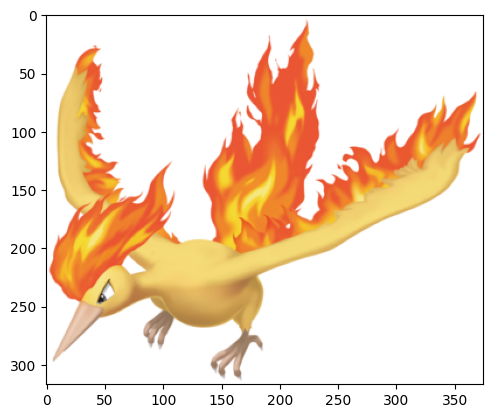

In [70]:
sulfura = "https://www.pokepedia.fr/images/thumb/d/db/Sulfura-DEPS.png/375px-Sulfura-DEPS.png"
predictImage(sulfura, loaded_model)

1/1 [==============================] - 0s 54ms/step
First predicted type: Ground_train: 32.26%
Second predicted type: Water_train: 16.19%
Third predicted type: Normal_train: 14.56%


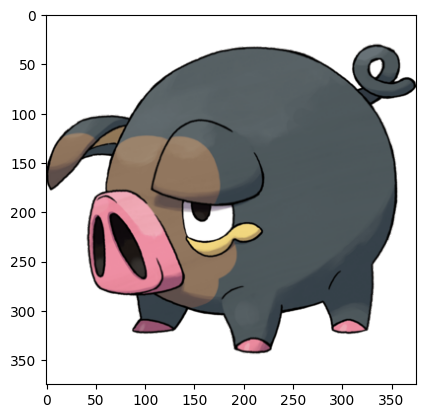

In [71]:
lechonk = "https://archives.bulbagarden.net/media/upload/thumb/7/75/0915Lechonk.png/375px-0915Lechonk.png"
predictImage(lechonk, loaded_model)

1/1 [==============================] - 0s 48ms/step
First predicted type: Fire_train: 87.56%
Second predicted type: Fighting_train: 7.46%
Third predicted type: Water_train: 2.68%


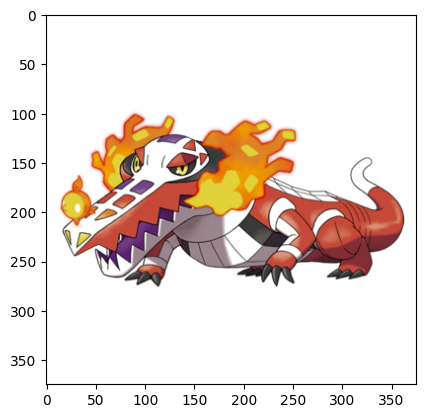

In [72]:
skeledirge = "https://archives.bulbagarden.net/media/upload/thumb/3/3e/0911Skeledirge.png/375px-0911Skeledirge.png"
predictImage(skeledirge, loaded_model)

1/1 [==============================] - 0s 51ms/step
First predicted type: Grass_train: 21.4%
Second predicted type: Flying_train: 11.29%
Third predicted type: Bug_train: 10.84%


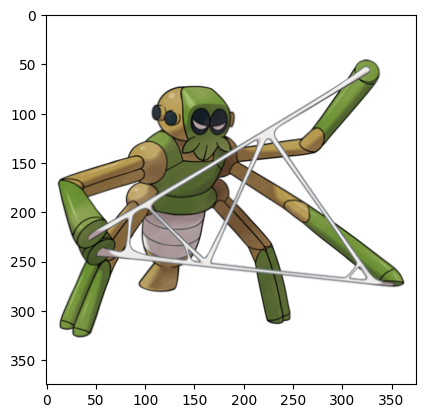

In [73]:
spidops = "https://archives.bulbagarden.net/media/upload/thumb/f/f3/0918Spidops.png/375px-0918Spidops.png"
predictImage(spidops, loaded_model)

1/1 [==============================] - 0s 47ms/step
First predicted type: Water_train: 31.16%
Second predicted type: Steel_train: 15.2%
Third predicted type: Flying_train: 14.65%


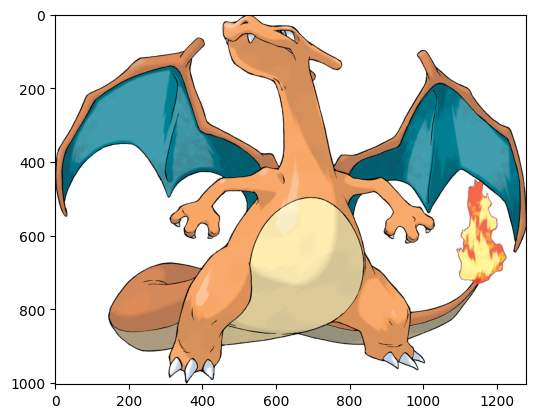

In [74]:
dracaufeu = "https://www.pokepedia.fr/images/1/17/Dracaufeu-RFVF.png"
predictImage(dracaufeu, loaded_model)

1/1 [==============================] - 0s 46ms/step
First predicted type: Fire_train: 37.07%
Second predicted type: Water_train: 18.05%
Third predicted type: Fighting_train: 13.8%


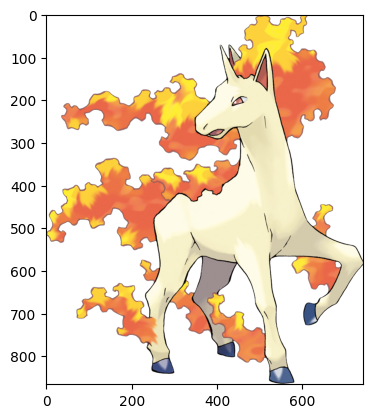

In [75]:
galopa = "https://www.pokepedia.fr/images/9/9c/Galopa-RFVF.png"
predictImage(galopa, loaded_model)

1/1 [==============================] - 0s 45ms/step
First predicted type: Water_train: 32.01%
Second predicted type: Ground_train: 27.75%
Third predicted type: Normal_train: 17.77%


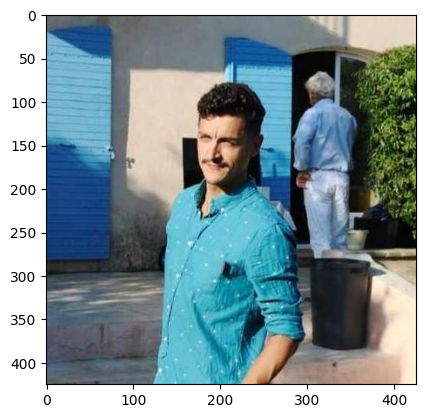

In [76]:
groubix = "https://avatars.githubusercontent.com/u/61580635?v=4"
predictImage(groubix, loaded_model)

1/1 [==============================] - 0s 45ms/step
First predicted type: Ground_train: 31.99%
Second predicted type: Water_train: 16.77%
Third predicted type: Rock_train: 16.03%


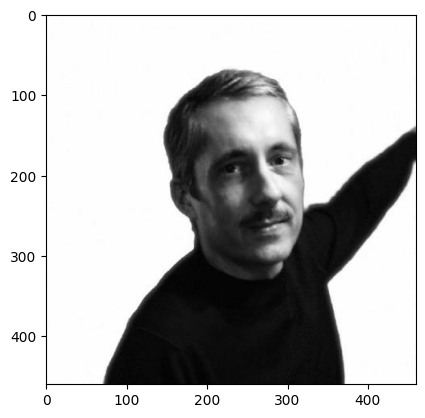

In [77]:
caspar = "https://avatars.githubusercontent.com/u/114233222?v=4"
predictImage(caspar, loaded_model)

1/1 [==============================] - 0s 47ms/step
First predicted type: Ground_train: 76.74%
Second predicted type: Ice_train: 17.61%
Third predicted type: Rock_train: 4.76%


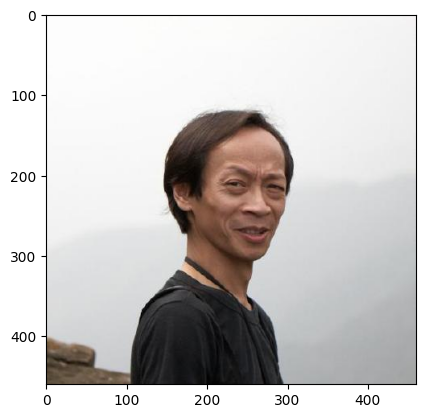

In [78]:
emile = "https://avatars.githubusercontent.com/u/71439067?v=4"
predictImage(emile, loaded_model)

1/1 [==============================] - 0s 48ms/step
First predicted type: Fairy_train: 27.24%
Second predicted type: Electric_train: 22.11%
Third predicted type: Water_train: 19.49%


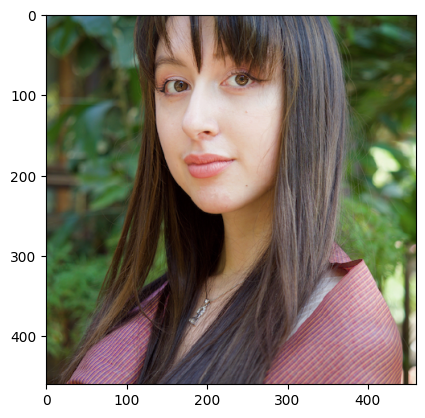

In [79]:
mo = "https://avatars.githubusercontent.com/u/103380937?v=4"
predictImage(mo, loaded_model)

1/1 [==============================] - 0s 44ms/step
First predicted type: Water_train: 40.32%
Second predicted type: Psychic_train: 16.34%
Third predicted type: Dark_train: 7.65%


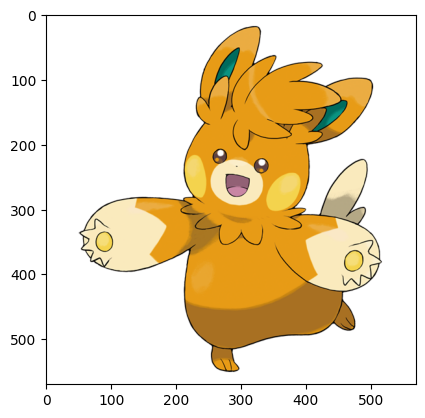

In [80]:
pawmot = "https://archives.bulbagarden.net/media/upload/3/32/0923Pawmot.png"
predictImage(pawmot, loaded_model)

1/1 [==============================] - 0s 45ms/step
First predicted type: Water_train: 88.51%
Second predicted type: Flying_train: 4.6%
Third predicted type: Fire_train: 3.83%


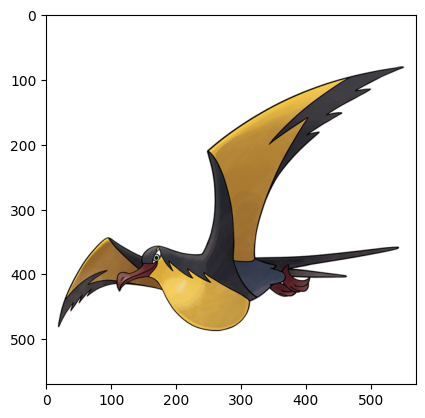

In [81]:
kilowattrel = "https://archives.bulbagarden.net/media/upload/e/ee/0941Kilowattrel.png"
predictImage(kilowattrel, loaded_model)

1/1 [==============================] - 0s 44ms/step
First predicted type: Water_train: 64.17%
Second predicted type: Flying_train: 11.51%
Third predicted type: Bug_train: 9.85%


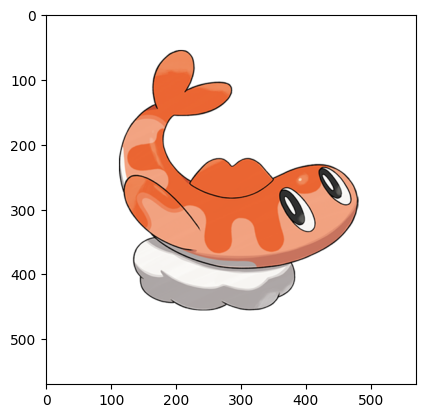

In [82]:
tatsugiri = "https://archives.bulbagarden.net/media/upload/3/34/0978Tatsugiri.png"
predictImage(tatsugiri, loaded_model)

1/1 [==============================] - 0s 45ms/step
First predicted type: Water_train: 49.21%
Second predicted type: Steel_train: 25.28%
Third predicted type: Flying_train: 13.94%


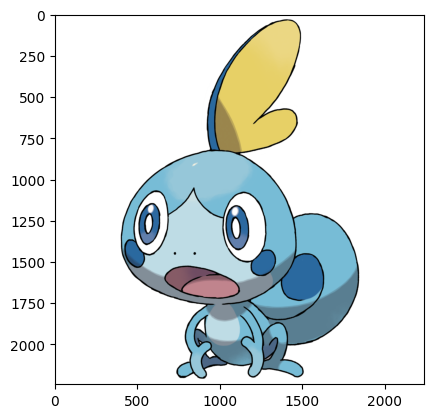

In [83]:
sobble = "https://archives.bulbagarden.net/media/upload/8/88/0816Sobble.png"
predictImage(sobble, loaded_model)

1/1 [==============================] - 0s 43ms/step
First predicted type: Normal_train: 44.7%
Second predicted type: Flying_train: 38.82%
Third predicted type: Bug_train: 4.91%


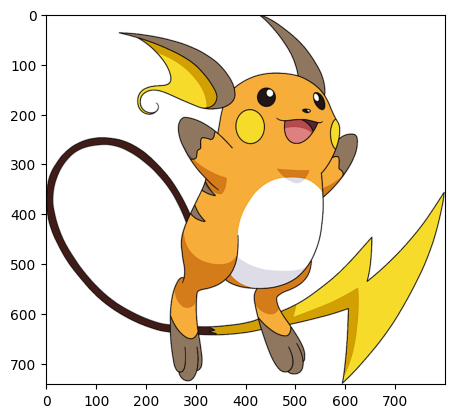

In [84]:
raichu = "https://static.pokemonpets.com/images/monsters-images-800-800/26-Raichu.webp"
predictImage(raichu, loaded_model)

1/1 [==============================] - 0s 44ms/step
First predicted type: Electric_train: 68.86%
Second predicted type: Psychic_train: 8.06%
Third predicted type: Normal_train: 6.43%


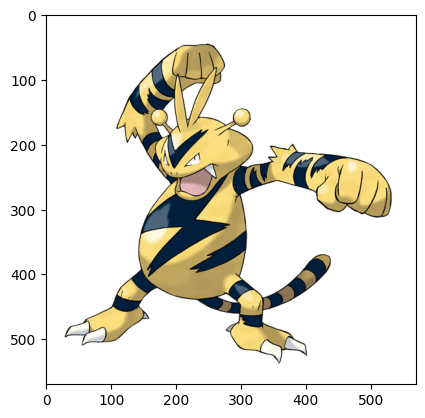

In [85]:
electabuzz = "https://archives.bulbagarden.net/media/upload/5/5c/0125Electabuzz.png"
predictImage(electabuzz, loaded_model)

1/1 [==============================] - 0s 46ms/step
First predicted type: Water_train: 27.87%
Second predicted type: Steel_train: 27.42%
Third predicted type: Electric_train: 17.09%


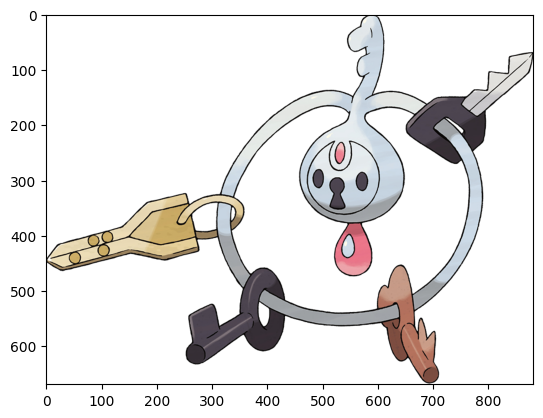

In [86]:
klefki = "https://www.pokepedia.fr/images/b/be/Trousselin-XY.png"
predictImage(klefki, loaded_model)

In [87]:
theffroi = "https://www.pokepedia.fr/images/0/09/Th%C3%A9ffroi-EB.png"
frissonille = "https://www.pokepedia.fr/images/b/be/Frissonille-EB.png"
applin = "https://archives.bulbagarden.net/media/upload/7/75/0840Applin.png"
clobbopus = "https://archives.bulbagarden.net/media/upload/2/2d/0852Clobbopus.png"
milcery = "https://archives.bulbagarden.net/media/upload/d/d0/0868Milcery.png"

1/1 [==============================] - 0s 59ms/step
First predicted type: Water_train: 39.82%
Second predicted type: Psychic_train: 19.73%
Third predicted type: Ghost_train: 19.43%


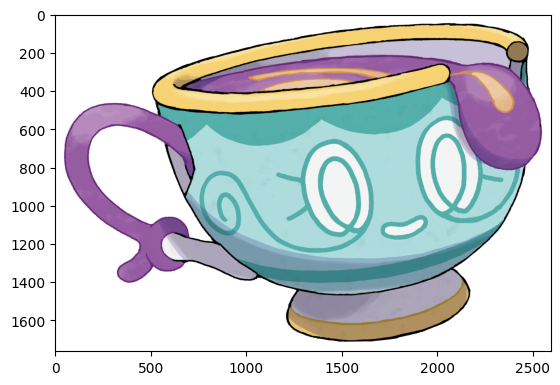

In [88]:
predictImage(theffroi, loaded_model)

1/1 [==============================] - 0s 51ms/step
First predicted type: Water_train: 33.45%
Second predicted type: Normal_train: 26.88%
Third predicted type: Ice_train: 12.64%


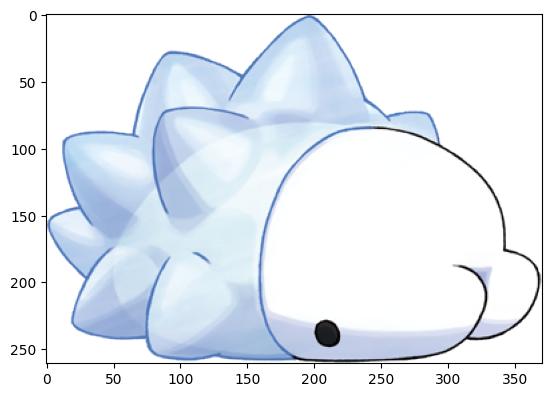

In [89]:
predictImage(frissonille, loaded_model)

1/1 [==============================] - 0s 49ms/step
First predicted type: Normal_train: 31.04%
Second predicted type: Water_train: 16.52%
Third predicted type: Fighting_train: 9.34%


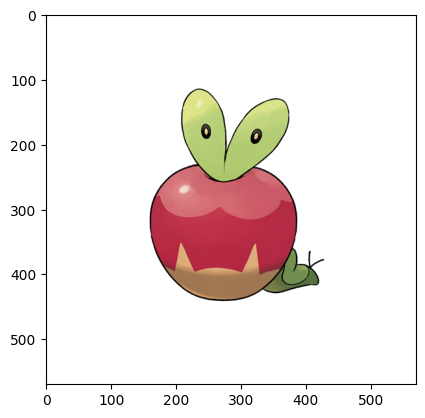

In [90]:
predictImage(applin, loaded_model)

1/1 [==============================] - 0s 44ms/step
First predicted type: Water_train: 22.29%
Second predicted type: Flying_train: 21.91%
Third predicted type: Steel_train: 12.14%


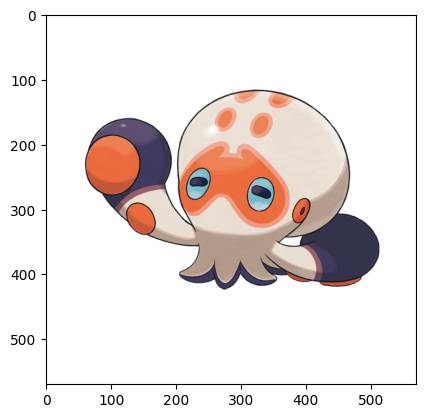

In [91]:
predictImage(clobbopus, loaded_model)

1/1 [==============================] - 0s 45ms/step
First predicted type: Water_train: 20.19%
Second predicted type: Normal_train: 18.15%
Third predicted type: Ground_train: 14.18%


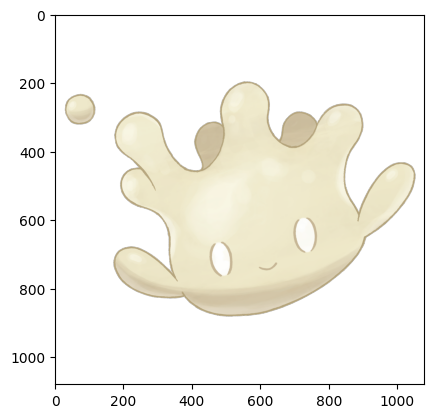

In [92]:
predictImage(milcery, loaded_model)

## From chemin image en local

In [93]:
ninjask = f"{types_path}/Bug/ninjask.png"
ninjask

'/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/types/Bug/ninjask.png'

1/1 [==============================] - 0s 49ms/step
First predicted type: Flying_train: 95.32%
Second predicted type: Bug_train: 3.97%
Third predicted type: Normal_train: 0.62%


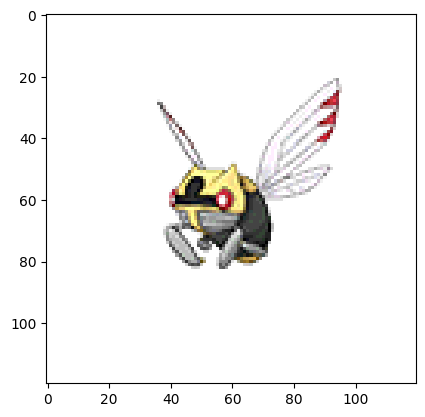

In [94]:
predictImage(ninjask, loaded_model)

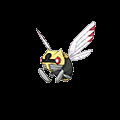

In [95]:
ninjask2 = load_img(f"{types_path}/Bug/ninjask.png")
ninjask2

In [96]:
type(ninjask2)

PIL.Image.Image

1/1 [==============================] - 0s 46ms/step
First predicted type: Flying_train: 95.32%
Second predicted type: Bug_train: 3.97%
Third predicted type: Normal_train: 0.62%


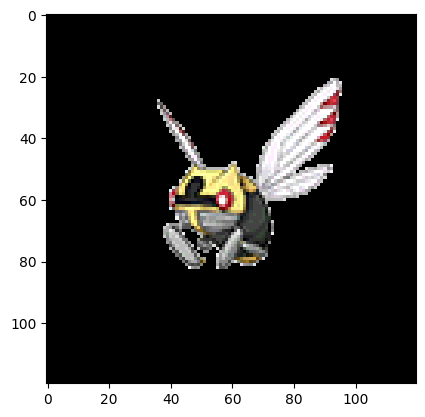

In [97]:
predictImage(ninjask2, loaded_model)